# 1) Compound channel + MRT beamformer

Purpose: build the effective BS→ID channel h = Hd + Hr Φ G and compute the MRT beamformer v (scaled to transmit power P0). This is the basic transmit model used in the SISE case. (See Section II and SISE formulation.

In [4]:
import numpy as np

def compound_channel(Hd, Hr, G, phases):
    """Compute Hd + Hr * diag(phases) * G
    Hd: (1 x NS), Hr: (1 x NR), G: (NR x NS), phases: length NR (complex unit-modulus)
    returns h (1 x NS)
    """
    Phi = np.diag(phases)
    return Hd + (Hr @ (Phi @ G))

def mrt_beamformer(h, P0):
    """Return MRT beamformer v (NS x 1) normalized to power P0"""
    v = h.conj().T                     # matched filter direction (NS x 1)
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.zeros_like(v)
    return v / norm * np.sqrt(P0)

# Example usage:
NS = 4; NR = 8
Hd = (np.random.randn(1,NS)+1j*np.random.randn(1,NS))/np.sqrt(2)
Hr = (np.random.randn(1,NR)+1j*np.random.randn(1,NR))/np.sqrt(2)
G  = (np.random.randn(NR,NS)+1j*np.random.randn(NR,NS))/np.sqrt(2)
phases = np.exp(1j * 2*np.pi * np.random.randint(0,2,size=NR) / 2)  # b=1 demo
P0 = 0.316 # 25 dBm ≈ 0.316 W (example)

h = compound_channel(Hd, Hr, G, phases)    # 1 x NS
v = mrt_beamformer(h, P0)                   # NS x 1
print("h shape", h.shape, "v shape", v.shape)


h shape (1, 4) v shape (4, 1)


# 2) Harvested energy calculation + feasibility check

Purpose: compute harvested RF power at an ER from the same transmit beam v (paper assumes no dedicated energy signal; harvested ≈ η⋅‖He v‖²). Use this to check the energy constraint E0. (See Equation (3) and SISE feasibility discussion.)

In [7]:
def harvested_power(He, v, eta=0.5):
    """He: (1 x NS) compound BS->ER channel, v: NS x 1 beamformer.
       Returns harvested RF power in linear Watts."""
    # norm(He @ v)^2 : received RF power (noise neglected in EH model)
    return eta * np.abs(He @ v)**2

# Example usage continuing from snippet 1
He = compound_channel(Hd, Hr, G, phases)   # if ER channels same dims; otherwise use distinct Hd_er,Hr_er
harvest = harvested_power(He, v, eta=0.5)
E0_required = 1e-6  # example threshold (Watts)
feasible = (harvest >= E0_required)
print(f"Harvested={harvest.item():.3e} W  Feasible={feasible}")


Harvested=2.190e+00 W  Feasible=[[ True]]


# 3) Element-by-element discrete-phase update (the core Alt-Opt step)

Purpose: for one IRS element n, try all discrete phases P and pick the phase that (a) satisfies the energy constraint and maximizes SNR, or (b) if none satisfy energy, picks the phase that maximizes SNR — exactly the practical element update rule used in the low-complexity alternating algorithm for SISE (equations (20) and (23) logic).

In [10]:
def try_element_update(n, phases, Hd_id, Hr_id, G, Hd_er, Hr_er, P0, sigma2, E0_required, eta, phase_set):
    """
    Try each discrete phase for IRS element n and pick best according to:
    - prefer candidates that meet harvested energy constraint; among them choose max SNR
    - if none meet E0, choose candidate with max SNR
    Returns chosen_phase (complex), chosen_snr (linear), chosen_harvest (linear)
    """
    best_phase = phases[n]
    best_snr = -1
    best_harvest = -1
    feasible_found = False

    for ph in phase_set:
        cand_phases = phases.copy()
        cand_phases[n] = ph
        # compound channels (ID and ER)
        h_id = compound_channel(Hd_id, Hr_id, G, cand_phases)   # 1 x NS
        v = mrt_beamformer(h_id, P0)                            # NS x 1
        # SNR
        snr = np.abs(h_id @ v)**2 / sigma2
        # harvested power
        He = compound_channel(Hd_er, Hr_er, G, cand_phases)
        harvested = harvested_power(He, v, eta)

        if harvested >= E0_required:
            # candidate is feasible
            if not feasible_found or snr > best_snr:
                feasible_found = True
                best_snr = snr
                best_phase = ph
                best_harvest = harvested
        else:
            # no feasible chosen yet; keep best SNR as fallback
            if not feasible_found and snr > best_snr:
                best_snr = snr
                best_phase = ph
                best_harvest = harvested

    return best_phase, best_snr, best_harvest

# Example usage (small demo loop updating element 0):
NS = 4; NR = 8
# generate independent channels for ID and ER in real use (here reused for simplicity)
Hd_id = (np.random.randn(1,NS)+1j*np.random.randn(1,NS))/np.sqrt(2)
Hr_id = (np.random.randn(1,NR)+1j*np.random.randn(1,NR))/np.sqrt(2)
Hd_er = (np.random.randn(1,NS)+1j*np.random.randn(1,NS))/np.sqrt(2)
Hr_er = (np.random.randn(1,NR)+1j*np.random.randn(1,NR))/np.sqrt(2)
G = (np.random.randn(NR,NS)+1j*np.random.randn(NR,NS))/np.sqrt(2)

# initialize phases (e.g., random discrete)
b = 2; L = 2**b
phase_set = np.exp(1j*2*np.pi*np.arange(L)/L)
phases = np.exp(1j*2*np.pi*np.random.randint(0,L,size=NR)/L)

P0 = 0.316; sigma2 = 1e-9; eta=0.5; E0_required = 1e-6
n = 0
chosen_phase, chosen_snr, chosen_harvest = try_element_update(
    n, phases, Hd_id, Hr_id, G, Hd_er, Hr_er, P0, sigma2, E0_required, eta, phase_set
)
print("chosen_phase angle (deg)", np.angle(chosen_phase,deg=True), "SNR(dB)", 10*np.log10(chosen_snr), "Harvest(W)", chosen_harvest)


chosen_phase angle (deg) 180.0 SNR(dB) [[103.96775753]] Harvest(W) [[0.88529061]]


NR= 4  SNR=129.14 dB  Harvested=3.95e-01 W  E0_req=1.00e-06
NR= 8  SNR=133.43 dB  Harvested=1.63e+00 W  E0_req=1.00e-06
NR=12  SNR=135.07 dB  Harvested=4.61e-01 W  E0_req=1.00e-06
NR=24  SNR=139.24 dB  Harvested=6.02e+00 W  E0_req=1.00e-06
NR=48  SNR=145.00 dB  Harvested=3.40e+00 W  E0_req=1.00e-06


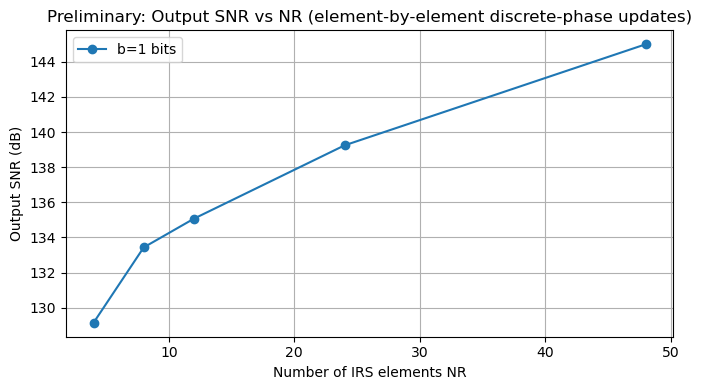

In [12]:
"""
IRS-aided SISE preliminary simulation (Python, numpy)
- Single ID (single antenna), single ER (single antenna) for simplicity
- Alternating element-by-element discrete-phase optimization
- Beamformer = MRT (conjugate of compound channel) for fixed IRS phases
- Computes received SNR and harvested energy
- Plots SNR vs NR to illustrate the 'SNR increases with NR' trend.

Requirements: numpy, matplotlib
Run: python irs_swipt_sise_sim.py
Author: assistant (based on Gong et al., IEEE IoT J., 2021)
"""

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Helper functions
# ---------------------------
def db2lin(db):
    return 10**(db/10)

def lin2db(x):
    return 10*np.log10(np.maximum(x, 1e-300))

# Small-scale channel generator (Rayleigh)
def rand_channel(rows, cols, scale=1.0):
    return (np.random.randn(rows, cols) + 1j*np.random.randn(rows, cols)) / np.sqrt(2) * scale

# Compound channel from BS to user via IRS: Hd (direct) + Hr * Phi * G
# Hd: (1 x NS), Hr: (1 x NR), G: (NR x NS)
def compound_channel(Hd, Hr, G, phases):
    # phases: length NR, complex reflection coefficients (amplitude=1)
    Phi = np.diag(phases)
    # Hr * Phi * G -> (1 x NR) * (NR x NR) * (NR x NS) => (1 x NS)
    reflected = (Hr @ (Phi @ G))
    return Hd + reflected

# Compute received SNR (single stream, noise power sigma2)
def received_snr(h, v, sigma2):
    # h: 1 x NS, v: NS x 1
    num = np.abs(h @ v)**2
    den = sigma2
    return (num/den).real.item()

# Harvested energy (approx) at ER: eta * |He * v|^2
def harvested_power(He, v, eta=1.0):
    # He: 1 x NS or NU x NS (but we will use single antenna ER) -> treat as 1xNS
    return eta * np.linalg.norm(He @ v)**2

# Discrete phase set
def discrete_phases(L):
    return np.exp(1j * 2*np.pi * np.arange(L) / L)

# ---------------------------------------
# Simulation parameters (change as needed)
# ---------------------------------------
np.random.seed(2025)

# System sizes
NS = 4          # BS antennas
# We'll sweep NR below
ER_single = True  # ER single-antenna (for simplicity)

# TX power and noise
P0_dBm = 25       # transmit power in dBm (as in paper default)
P0 = 10**((P0_dBm-30)/10)  # convert to Watts
sigma2_dbm = -90  # noise power in dBm
sigma2 = 10**((sigma2_dbm-30)/10)

eta = 0.5         # energy harvesting efficiency
E0_required = 1e-6  # required harvested energy (Watts) — tune to be feasible/infeasible

# Discrete phase resolution
b = 1             # bits per element (b=1 => L=2 phases), try 1 or 2
L = 2**b
phase_set = discrete_phases(L)

# Geometry/pathloss simplified (we skip detailed PL; use scale factors)
pathloss_direct = 1.0
pathloss_reflect = 1.0

# Sweep NR
NR_list = [4, 8, 12, 24, 48]  # number of IRS elements to test
max_outer_iters = 6

# Results storage
snr_results_db = []

# Main sweep
for NR in NR_list:
    # Create channels
    # Hd: direct BS->ID (1 x NS)
    Hd_id = rand_channel(1, NS, scale=np.sqrt(pathloss_direct))
    # Hr_id: IRS->ID (1 x NR)
    Hr_id = rand_channel(1, NR, scale=np.sqrt(pathloss_reflect))
    # G: BS->IRS (NR x NS)
    G = rand_channel(NR, NS, scale=np.sqrt(pathloss_reflect))
    # For ER (single antenna), He = Hd_er + Hr_er * Phi * G
    Hd_er = rand_channel(1, NS, scale=np.sqrt(pathloss_direct))
    Hr_er = rand_channel(1, NR, scale=np.sqrt(pathloss_reflect))

    # Initialize IRS phases randomly (choose one from discrete set)
    phases_idx = np.random.randint(0, L, size=NR)
    phases = np.exp(1j * 2*np.pi * phases_idx / L)

    prev_snr = -1
    for outer in range(max_outer_iters):
        # 1) Given phases, compute compound channel to ID
        h_id = compound_channel(Hd_id, Hr_id, G, phases)  # 1 x NS

        # 2) Beamformer: MRT (conjugate of h_id), scaled to power P0
        v = h_id.conj().T
        v = v / np.linalg.norm(v) * np.sqrt(P0)  # NS x 1

        # 3) Check current SNR and harvested energy
        snr = received_snr(h_id, v, sigma2)
        He_compound = compound_channel(Hd_er, Hr_er, G, phases)  # 1 x NS
        harvested = harvested_power(He_compound, v, eta)

        # 4) Element-by-element update of phases (one pass)
        for n in range(NR):
            best_phase = phases[n]
            best_snr = -1
            best_harvest = None
            # try each discrete phase for element n
            for ph in phase_set:
                candidate_phases = phases.copy()
                candidate_phases[n] = ph
                # recompute compound channel and beamformer quickly
                h_id_cand = compound_channel(Hd_id, Hr_id, G, candidate_phases)
                v_cand = h_id_cand.conj().T
                v_cand = v_cand / np.linalg.norm(v_cand) * np.sqrt(P0)
                snr_cand = received_snr(h_id_cand, v_cand, sigma2)
                # harvested
                He_cand = compound_channel(Hd_er, Hr_er, G, candidate_phases)
                harvested_cand = harvested_power(He_cand, v_cand, eta)
                # Choose the candidate that maximizes SNR while satisfying energy constraint
                # If no candidate satisfies energy, we take best SNR (report infeasible later)
                feasible = (harvested_cand >= E0_required)
                if harvested >= E0_required:  # current overall feasible -> prefer candidates that keep feasibility
                    if feasible and snr_cand > best_snr:
                        best_snr = snr_cand
                        best_phase = ph
                        best_harvest = harvested_cand
                else:
                    # if currently infeasible, select candidate that maximizes harvested energy first until feasible,
                    # or else maximize SNR as fallback
                    if feasible and best_harvest is None:
                        # prefer feasibility
                        best_snr = snr_cand
                        best_phase = ph
                        best_harvest = harvested_cand
                    elif best_harvest is None:
                        # still no feasible candidate chosen yet -> maximize SNR
                        if snr_cand > best_snr:
                            best_snr = snr_cand
                            best_phase = ph
                            best_harvest = harvested_cand
            # update phase n
            phases[n] = best_phase

        # After full pass, recompute metrics
        h_id = compound_channel(Hd_id, Hr_id, G, phases)
        v = h_id.conj().T
        v = v / np.linalg.norm(v) * np.sqrt(P0)
        snr_new = received_snr(h_id, v, sigma2)
        He_compound = compound_channel(Hd_er, Hr_er, G, phases)
        harvested = harvested_power(He_compound, v, eta)

        if abs(snr_new - prev_snr) / (abs(prev_snr)+1e-12) < 1e-3:
            break
        prev_snr = snr_new

    # Store result
    snr_results_db.append(lin2db(snr_new))
    print(f"NR={NR:2d}  SNR={lin2db(snr_new):.2f} dB  Harvested={harvested:.2e} W  E0_req={E0_required:.2e}")

# Plot SNR vs NR
plt.figure(figsize=(7,4))
plt.plot(NR_list, snr_results_db, marker='o', label=f'b={b} bits')
plt.grid(True)
plt.xlabel('Number of IRS elements NR')
plt.ylabel('Output SNR (dB)')
plt.title('Preliminary: Output SNR vs NR (element-by-element discrete-phase updates)')
plt.legend()
plt.tight_layout()
plt.show()
